# **Cardiotocografia**

## **Temática**

Esse trabalho foi desenvolvido utilizando uma base de dados acessível no website da UCI ([disponível aqui](https://archive.ics.uci.edu/dataset/193/cardiotocography)) que se trata de dados coletados de exames de cardiotocografia em fetos para o diagnóstico de possível patologia.

## **Imports**

Nessa seção foi realizada a inclusão de todas as bibliotecas necessárias para o desenvolvimento do projeto.

In [84]:
import torch
import sklearn

import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn import preprocessing

%matplotlib inline

Aqui criei variáveis globais para guardar informações como os hiperparâmetros que serão utilizados no treinamento da rede neural.

In [85]:
# Semente para a randomização da escolha dos dados da base de dados
RANDOM_SEED = 42

# Quantidade de rótulos que há para classificar os objetos da base de dados
NUM_CLASSES = 3

# Nome das classes (0) Normal, (1) Suspeito, (2) Patológico
CLASSES = ["Normal", "Suspeito", "Patológico"]

# Quantidade de entradas da rede neural (base de dados possui 23 atributos - desconsiderando o rotúlo)
INPUT_DIMENSON = 23

# Quantidade de épocas escolhida
EPOCHS = 300

# Melhor taxa de aprendizado escolhida para essa base
LEARNING_RATE = 0.00001

# Escolha de CPU ou GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Fornece a semente para as bibliotecas que a utilizam
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## **Base de dados**

Importa a base de dados a ser utilizada. Baixei a base da UCI e disponibilizei a em um repositório do GitHub para fácil acesso.

In [86]:
url = "https://raw.githubusercontent.com/leojgpereira/t2-ia/main/CTG%20Dataset.csv"
ctg = pd.read_csv(url)

Mostra a base de dados completa

In [87]:
ctg

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120,120,0,0,0,73,0.5,43,2.4,0,...,62,126,2,0,120,137,121,73,1,1
1,132,132,4,0,4,17,2.1,0,10.4,2,...,68,198,6,1,141,136,140,12,0,0
2,133,133,2,0,5,16,2.1,0,13.4,2,...,68,198,5,1,141,135,138,13,0,0
3,134,134,2,0,6,16,2.4,0,23.0,2,...,53,170,11,0,137,134,137,13,1,0
4,132,132,4,0,5,16,2.4,0,19.9,0,...,53,170,9,0,137,136,138,11,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140,140,0,0,6,79,0.2,25,7.2,0,...,137,177,4,0,153,150,152,2,0,1
2122,140,140,1,0,9,78,0.4,22,7.1,0,...,103,169,6,0,152,148,151,3,1,1
2123,140,140,1,0,7,79,0.4,20,6.1,0,...,103,170,5,0,153,148,152,4,1,1
2124,140,140,1,0,9,78,0.4,27,7.0,0,...,103,169,6,0,152,147,151,4,1,1


Mostra a contagem de itens de cada classe


*   0 - Normal
*   1 - Suspeito
*   2 - Patológico



In [88]:
ctg['NSP'].value_counts()

0    1655
1     295
2     176
Name: NSP, dtype: int64

Divide a base de dados em base de treino (70%), validação (20%) e teste (10%).

In [89]:
dataset_train, dataset_test = train_test_split(ctg, test_size = 0.3, random_state = RANDOM_SEED, shuffle = True, stratify = ctg.NSP)
dataset_test, dataset_val = train_test_split(dataset_test, test_size = 0.66, random_state = RANDOM_SEED, shuffle = True, stratify = dataset_test.NSP)

Mostra a distribuição de classes em cada divisão de dataset.

In [90]:
print("Train")
print(dataset_train.NSP.value_counts())
print()
print("Val")
print(dataset_val.NSP.value_counts())
print()
print("Test")
print(dataset_test.NSP.value_counts())

Train
0    1158
1     207
2     123
Name: NSP, dtype: int64

Val
0    329
1     58
2     35
Name: NSP, dtype: int64

Test
0    168
1     30
2     18
Name: NSP, dtype: int64


## **Modelo**

Classe responsável por modelar a arquitetura (camadas e funções de ativação) do modelo.

In [91]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.entryLayer = nn.Linear(INPUT_DIMENSON, 13)
    self.hiddenLayer1 = nn.Linear(13, 21)
    self.hiddenLayer2 = nn.Linear(21, 52)
    self.hiddenLayer3 = nn.Linear(52, 89)
    self.outputLayer = nn.Linear(89, NUM_CLASSES)

  def forward(self, input):
    input = F.relu(self.entryLayer(input))
    input = F.relu(self.hiddenLayer1(input))
    input = F.relu(self.hiddenLayer2(input))
    input = F.relu(self.hiddenLayer3(input))
    output = F.relu(self.outputLayer(input))

    return output

Instância o modelo e define o otimizador e a função de loss a ser utilizada. Para este projeto utilizei o otimizador AdamW e a função de loss Cross Entropy.

In [92]:
model = MLP()
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

loss_function = nn.CrossEntropyLoss().to(device)

Separa os atributos do rótulo em cada dataset e converte para um numpy array.

In [93]:
x_train = (dataset_train.loc[:, dataset_train.columns != "NSP"]).to_numpy()
y_train = (dataset_train.loc[:, dataset_train.columns == "NSP"])
y_train = preprocessing.LabelEncoder().fit_transform(y_train)

x_val = (dataset_val.loc[:, dataset_val.columns != "NSP"]).to_numpy()
y_val = (dataset_val.loc[:, dataset_train.columns == "NSP"])
y_val = preprocessing.LabelEncoder().fit_transform(y_val)

x_test = (dataset_test.loc[:, dataset_test.columns != "NSP"]).to_numpy()
y_test = (dataset_test.loc[:, dataset_train.columns == "NSP"])
y_test = preprocessing.LabelEncoder().fit_transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Transforma os numpy arrays em tensores do PyTorch para o treinamento do modelo

In [94]:
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()

x_val = Variable(torch.from_numpy(x_val)).float()
y_val = Variable(torch.from_numpy(y_val)).long()

x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()

Coloca os tensores na GPU, quando a mesma estiver disponível.

In [95]:
x_train = x_train.to(device)
y_train = y_train.to(device)

x_val = x_val.to(device)
y_val = y_val.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

## **Treino**

Treinamento do modelo.

In [96]:
# Cria listas para guardar os valores de loss e acurácia em cada época
train_accuracy_list = []
train_loss_list = []

val_accuracy_list = []
val_loss_list = []

# Variável utilizada para saber quando salvar o melhor modelo
best_accuracy = 0

for epoch in range(EPOCHS):
  print("Epoch %d/%d" % (epoch + 1, EPOCHS))
  print("-" * 54)

  # Passa a entrada de treino para o modelo
  y_pred = model(x_train)

  # Calcula a loss de treino e guarda na lista
  train_loss = loss_function(y_pred, y_train)
  train_loss_list.append(train_loss.item())

  # Calcula a acurácia de treino e guarda na lista
  train_accuracy = ((torch.argmax(y_pred, dim=1) == y_train).type(torch.FloatTensor)).mean()
  train_accuracy_list.append(train_accuracy)

  print("Loss (Train)     : %.8f --> Accuracy: %.8f" % (train_loss, train_accuracy))

  # Zera os gradientes e recalcula fazendo o backpropagation
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  # Avaliação do conjunto de validação
  with torch.no_grad():
    # Passa a entrada de validação no modelo
    y_pred = model(x_val)

    # Calcula a loss de validação e adiciona o valor na lista
    val_loss = loss_function(y_pred, y_val)
    val_loss_list.append(val_loss.item())

    # Calcula a acurácia de validação e salva na lista
    val_accuracy = ((torch.argmax(y_pred, dim=1) == y_val).type(torch.FloatTensor)).mean()
    val_accuracy_list.append(val_accuracy)

    # Verifica se a acurácia obtida no conjunto de validação é a melhor obtida até o momento
    if val_accuracy > best_accuracy:
      # Salva o modelo
      torch.save(model.state_dict(), 'CTGModel.pth')
      # Atualiza a acurácia do melhor modelo
      best_accuracy = val_accuracy

    print("Loss (Validation): %.8f --> Accuracy: %.8f" % (val_loss, val_accuracy))
    print()

Epoch 1/300
------------------------------------------------------
Loss (Train)     : 1.10186517 --> Accuracy: 0.47311828
Loss (Validation): 1.08991206 --> Accuracy: 0.51895732

Epoch 2/300
------------------------------------------------------
Loss (Train)     : 1.09842193 --> Accuracy: 0.48051074
Loss (Validation): 1.08651018 --> Accuracy: 0.52369666

Epoch 3/300
------------------------------------------------------
Loss (Train)     : 1.09499097 --> Accuracy: 0.49059141
Loss (Validation): 1.08312225 --> Accuracy: 0.53317535

Epoch 4/300
------------------------------------------------------
Loss (Train)     : 1.09157348 --> Accuracy: 0.49731183
Loss (Validation): 1.07974708 --> Accuracy: 0.53791469

Epoch 5/300
------------------------------------------------------
Loss (Train)     : 1.08817279 --> Accuracy: 0.50873655
Loss (Validation): 1.07638526 --> Accuracy: 0.54265404

Epoch 6/300
------------------------------------------------------
Loss (Train)     : 1.08478749 --> Accuracy:

## **Métricas**

Plota o gráfico da acurácia de treino e validação ao longo das épocas.

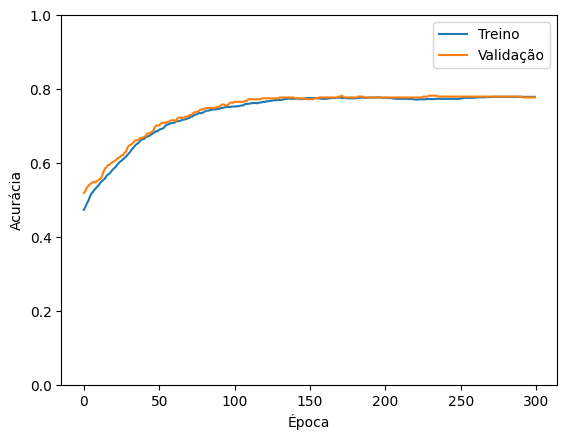

In [97]:
train_acc_list = [acc.cpu().numpy() for acc in train_accuracy_list]
val_acc_list = [acc.cpu().numpy() for acc in val_accuracy_list]

plt.ylim([0, 1]);
plt.plot(train_acc_list, label = "Treino")
plt.plot(val_acc_list, label = "Validação")
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend()
plt.show()

Plota o gráfico da loss de treino e validação ao longo das épocas.

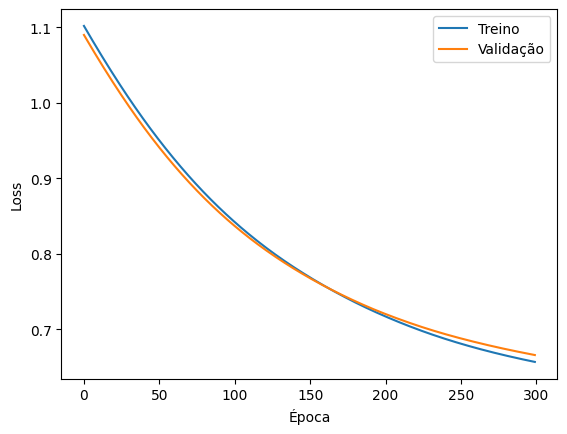

In [98]:
plt.plot(train_loss_list, label = "Treino")
plt.plot(val_loss_list, label = "Validação")
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend()
plt.show()

Função usada para calcular a predição dos dados de teste para a avaliação de algumas métricas

In [104]:
def predictions(model, dataset):
  model = model.eval()

  predictions = []
  prediction_probabilities = []
  real_values = []

  with torch.no_grad():
    y_pred = model(dataset)

    preds = torch.argmax(y_pred, dim=1)

    probs = F.softmax(y_pred, dim = 1)

    predictions.extend(preds)
    prediction_probabilities.extend(probs)

  predictions = torch.stack(predictions).cpu()
  prediction_probabilities = torch.stack(prediction_probabilities).cpu()

  return predictions, prediction_probabilities

Carrega o melhor modelo obtido durante o treino do modelo e o utiliza para realizar as predições no dataset de teste.

O link para download do melhor modelo obtido encontrasse no [Google Drive](https://drive.google.com/file/d/10CAqVF7OZ6K_x1xs2L2HgVBx8rswO3jt/view?usp=sharing) e no [GitHub](https://github.com/leojgpereira/t2-ia/raw/main/CTGModel.pth).

In [105]:
MODEL_PATH = "/content/CTGModel.pth"

saved_model = MLP();
saved_model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
saved_model.to(device)

y_pred, y_pred_probs = predictions(
  saved_model,
  x_test
)

Mostra algumas métricas de avaliação do modelo no conjunto de testes.

In [106]:
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names = CLASSES))

              precision    recall  f1-score   support

      Normal       0.80      0.98      0.88       168
    Suspeito       0.20      0.03      0.06        30
  Patológico       0.50      0.11      0.18        18

    accuracy                           0.78       216
   macro avg       0.50      0.38      0.37       216
weighted avg       0.69      0.78      0.71       216



Função encapsulada para criar a matriz de confusão.

In [107]:
def create_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha = 'right')
  plt.ylabel('Diagnóstico')
  plt.xlabel('Predição');

Cria a matriz de confusão baseado na avaliação do dataset de testes.

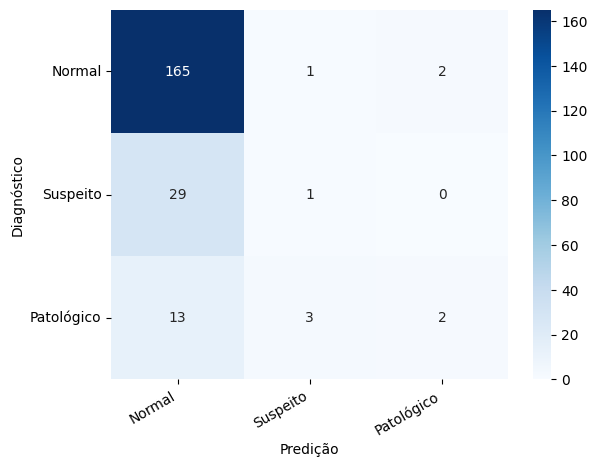

In [108]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = CLASSES, columns = CLASSES)

create_confusion_matrix(df_cm)

Como o dataset não possuia uma quantidade proporcional de itens de cada classe, o modelo foi muito melhor em detectar diagnósticos "Normal" nas cardiotocografias dado que havia poucos diagnósticos "Suspeito" e "Patológico".

## **Resultados**

Todos os modelos treinados utilizaram a função de ativação Relu.

### Treino 1

Learning Rate = 0.01

Epochs = 5

Número de camadas = 4
*   Camada de Entrada: 23 entradas, 13 saídas
*   1ª Camada: 13 entradas, 4 saídas
*   2ª Camada: 4 entradas, 16 saídas
*   Camada de Saída: 16 entradas, 3 saídas

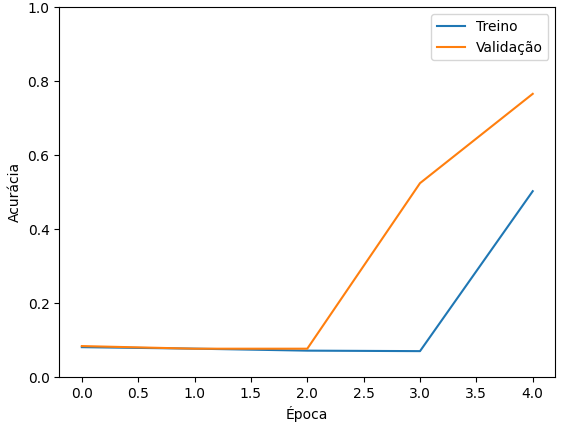

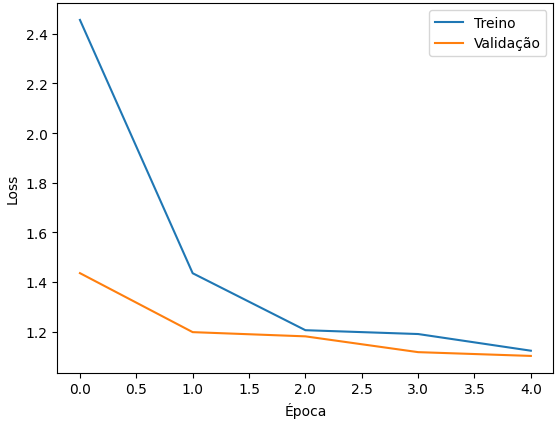

### Treino 2

Learning Rate = 0.001

Epochs = 100

Número de camadas = 4
*   Camada de Entrada: 23 entradas, 13 saídas
*   1ª Camada: 13 entradas, 30 saídas
*   2ª Camada: 30 entradas, 42 saídas
*   Camada de Saída: 42 entradas, 3 saídas

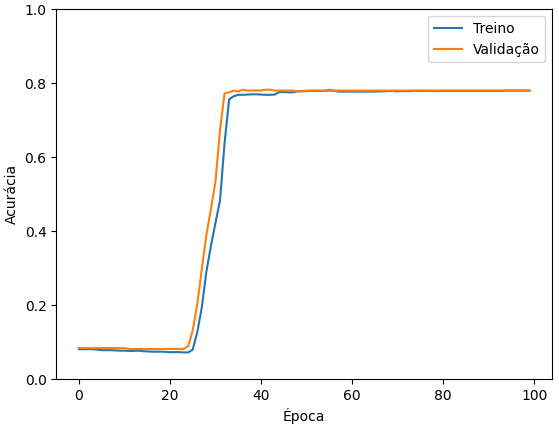

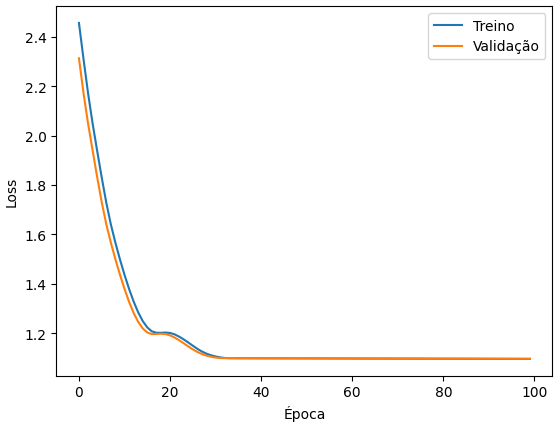

### Treino 3

Learning Rate = 0.0001

Epochs = 200

Número de camadas = 4
*   Camada de Entrada: 23 entradas, 13 saídas
*   1ª Camada: 13 entradas, 30 saídas
*   2ª Camada: 30 entradas, 8 saídas
*   Camada de Saída: 8 entradas, 3 saídas

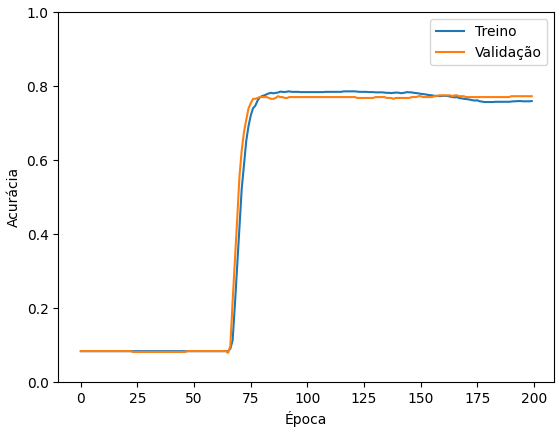

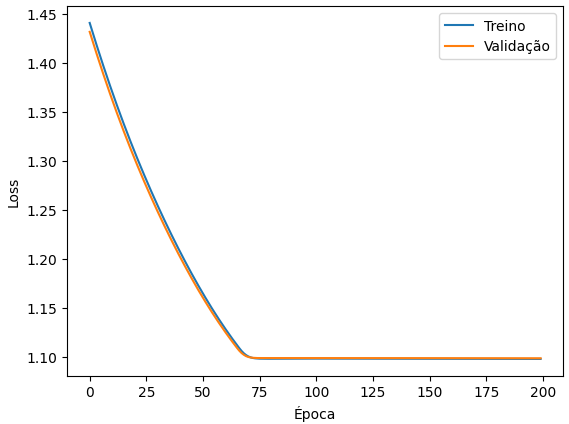

### Treino 4

Learning Rate = 0.0001

Epochs = 200

Número de camadas = 5

*   Camada de Entrada: 23 entradas, 13 saídas
*   1ª Camada: 13 entradas, 30 saídas
*   2ª Camada: 30 entradas, 42 saídas
*   3ª Camada: 42 entradas, 30 saídas
*   Camada de Saída: 30 entradas, 3 saídas



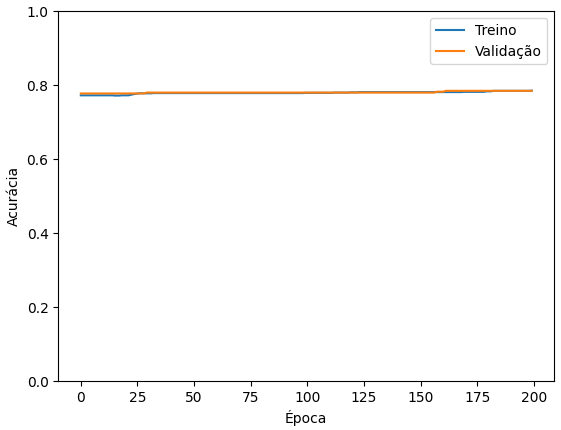

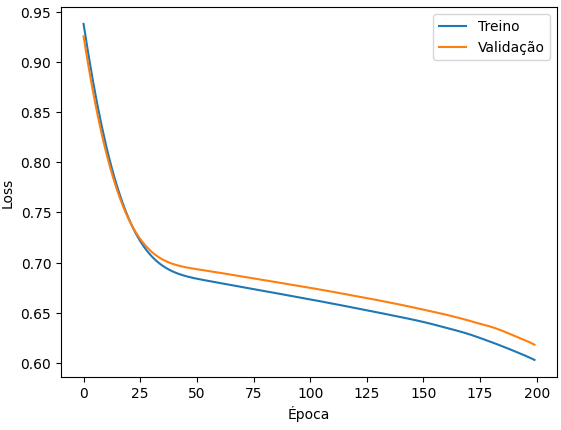

### Treino 5 (Resultado Final)

Learning Rate = 0.00001

Epochs = 300

Número de camadas = 5
*   Camada de Entrada: 23 entradas, 13 saídas
*   1ª Camada: 13 entradas, 21 saídas
*   2ª Camada: 21 entradas, 52 saídas
*   3ª Camada: 52 entradas, 89 saídas
*   Camada de Saída: 89 entradas, 3 saídas

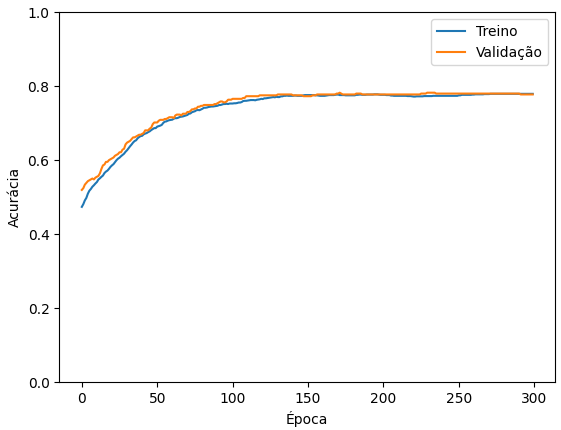

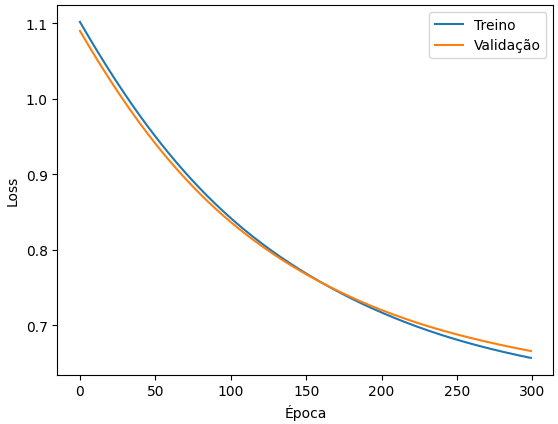